In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install category_encoders
import category_encoders as ce
!pip install keras
import keras
from keras import layers
!pip install keras-tuner -q
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
!pip install imblearn
import imblearn
from imblearn.over_sampling import SMOTENC, RandomOverSampler

2024-03-18 17:42:30.798259: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 17:42:30.799039: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 17:42:30.803781: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 17:42:30.865208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 17:42:31.878379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

### Pre-processing

In [2]:
df = pd.read_csv("https://minio.lab.sspcloud.fr/jbrablx/ai_insurance/raw/train.csv")
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [3]:
#Category variables
df['Vehicle_Damage'] = np.where(df['Vehicle_Damage']!= 'Yes', 1, 0)
df['Gender'] = np.where(df['Gender']!= 'Male', 1, 0)
cats = ['< 1 Year', '1-2 Year', '> 2 Years']
df['Vehicle_Age'] = pd.Categorical(df['Vehicle_Age'],ordered=True, categories=cats)

In [4]:
#Split input/output variable(s)
x = df.drop(['Response', 'id'], axis=1)
y = df[['Response']]

In [5]:
#One-hot encoding for Vehicle_Age
encoder = ce.OrdinalEncoder(cols=['Vehicle_Age'])
x = encoder.fit_transform(x)

In [6]:
seed = 42
epochs = 10
batch_size = 100

In [7]:
#Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)

In [8]:
#Scaling the data using the sklearn StandardScaler to set the mean to 0 and standard deviation to 1.
scaler=sc()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

#### Re-sampling vs weight classes

In [9]:
method = "None"
#Re-sampling
if method == "SMOTE":
    print("SMOTE")
    print("--------")
    cat_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Vehicle_Age']
    smote = SMOTENC(random_state=seed, k_neighbors=15, categorical_features=cat_features)
    x_train, y_train = smote.fit_resample(x_train, y_train)
#Re-sampling
elif method == "OVER":
    print("RandomOverSampler")
    print("--------")
    rs = RandomOverSampler(random_state=seed)
    x_train, y_train = rs.fit_resample(x_train, y_train)
#Weight classes
elif method == "WEIGHTS" :
    print("CLASSWEIGHTS")
    print("--------")
    neg, pos = np.bincount(np.reshape(y_train, y_train.size))
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all stays the same.
    weight_for_0 = (1 / neg)*(neg+pos)/2.0 
    weight_for_1 = (1 / pos)*(neg+pos)/2.0
    class_weights = {0: weight_for_0, 1: weight_for_1}
    print('Weight for class 0: {:.2f}\n'.format(weight_for_0),
          'Weight for class 1: {:.2f}'.format(weight_for_1))
else:
    class_weights = None

In [10]:
#Validation-train split
x_val, x_train, y_val, y_train = train_test_split(x_train, y_train, test_size=0.8, stratify=y_train, random_state=seed)

x_val_train, x_val_test, y_val_train, y_val_test = train_test_split(x_val, y_val, test_size=0.2, stratify=y_val, random_state=seed)


### Determining the best hyperparameters

#### 1st neural network

In [11]:
#Neural network structure
def call_existing_code_1(units, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Dense(units=units, activation='relu', input_dim = 10))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["f1_score"],
    )
    return model

#Range of values to be tested for the hyperparameters
def build_model_1(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code_1(
        units=units, dropout=dropout, lr=lr
    )
    return model


build_model_1(keras_tuner.HyperParameters())

/opt/mamba/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [12]:
#Search for best hyperparameter values
tuner_1 = keras_tuner.RandomSearch(
    hypermodel=build_model_1,
    objective="f1_score",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir_1",
    project_name="helloworld_1",
)

tuner_1.search_space_summary()

tuner_1.search(x_val_train, y_val_train, epochs=epochs, batch_size = batch_size, validation_data=(x_val_test, y_val_test))


Trial 10 Complete [00h 00m 24s]
f1_score: 0.21837104856967926

Best f1_score So Far: 0.21837104856967926
Total elapsed time: 00h 04m 53s


In [13]:
tuner_1.results_summary()

best_hps = tuner_1.get_best_hyperparameters(5)
model_1 = build_model_1(best_hps[0])

Results summary
Results in my_dir_1/helloworld_1
Showing 10 best trials
Objective(name="f1_score", direction="min")

Trial 00 summary
Hyperparameters:
units: 416
dropout: True
lr: 0.005267900351839842
Score: 0.21837104856967926

Trial 01 summary
Hyperparameters:
units: 384
dropout: True
lr: 0.00011954399938830767
Score: 0.21837104856967926

Trial 02 summary
Hyperparameters:
units: 224
dropout: True
lr: 0.00011919843309614942
Score: 0.21837104856967926

Trial 03 summary
Hyperparameters:
units: 288
dropout: False
lr: 0.00012739081302807814
Score: 0.21837104856967926

Trial 04 summary
Hyperparameters:
units: 128
dropout: True
lr: 0.007011435753473696
Score: 0.21837104856967926

Trial 05 summary
Hyperparameters:
units: 64
dropout: False
lr: 0.0005990969855590758
Score: 0.21837104856967926

Trial 06 summary
Hyperparameters:
units: 160
dropout: True
lr: 0.0029710284502994224
Score: 0.21837104856967926

Trial 07 summary
Hyperparameters:
units: 256
dropout: False
lr: 0.00484147189732174
Score:

#### 2nd neural network (fully connected neural network)

In [14]:
#Neural network structure
def call_existing_code_2(units_1, units_2, units_3, lr):
    model = keras.Sequential()
    model.add(keras.Input(shape=(10,)))
    model.add(keras.layers.Dense(units_1, activation='relu')) 
    model.add(keras.layers.Dense(units_2, activation='relu'))
    model.add(keras.layers.Dense(units_3, activation='relu')) 
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr), 
        loss=keras.losses.BinaryCrossentropy(), 
        metrics=['f1_score'])
    return model

#Range of values to be tested for the hyperparameters
def build_model_2(hp):
    units_1 = hp.Int("units_1", min_value=32, max_value=512, step=32)
    units_2 = hp.Int("units_2", min_value=32, max_value=512, step=32)
    units_3 = hp.Int("units_3", min_value=32, max_value=512, step=32)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code_2(
        units_1=units_1, units_2=units_2, units_3=units_3, lr=lr
    )
    return model


build_model_2(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=True>

In [15]:
#Search for best hyperparameter values
tuner_2 = keras_tuner.RandomSearch(
    hypermodel=build_model_2,
    objective="f1_score",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir_2",
    project_name="helloworld_2",
)

tuner_2.search_space_summary()

tuner_2.search(x_val_train, y_val_train, epochs=epochs, batch_size = batch_size, validation_data=(x_val_test, y_val_test))


Trial 10 Complete [00h 01m 17s]
f1_score: 0.21837104856967926

Best f1_score So Far: 0.21837104856967926
Total elapsed time: 00h 08m 36s


In [16]:
tuner_2.results_summary()

best_hps = tuner_2.get_best_hyperparameters(5)
model_2 = build_model_2(best_hps[0])

Results summary
Results in my_dir_2/helloworld_2
Showing 10 best trials
Objective(name="f1_score", direction="min")

Trial 00 summary
Hyperparameters:
units_1: 352
units_2: 480
units_3: 512
lr: 0.0011500145713744404
Score: 0.21837104856967926

Trial 01 summary
Hyperparameters:
units_1: 64
units_2: 416
units_3: 416
lr: 0.0011140493525027336
Score: 0.21837104856967926

Trial 02 summary
Hyperparameters:
units_1: 512
units_2: 96
units_3: 192
lr: 0.0004247879117781972
Score: 0.21837104856967926

Trial 03 summary
Hyperparameters:
units_1: 224
units_2: 352
units_3: 480
lr: 0.00704424116535504
Score: 0.21837104856967926

Trial 04 summary
Hyperparameters:
units_1: 192
units_2: 448
units_3: 512
lr: 0.00019456631271994395
Score: 0.21837104856967926

Trial 05 summary
Hyperparameters:
units_1: 96
units_2: 480
units_3: 64
lr: 0.0030319628359035174
Score: 0.21837104856967926

Trial 06 summary
Hyperparameters:
units_1: 32
units_2: 192
units_3: 64
lr: 0.00023273998841816132
Score: 0.21837104856967926



### k-Fold Cross-Validation

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 352)            │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 480)            │       169,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       246,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,097 (1.60 MB)

 Trainable params: 420,097 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2177 - loss: 0.5116
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2171 - loss: 0.3173
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2184 - loss: 0.2964
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2176 - loss: 0.2857
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2192 - loss: 0.2838
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2173 - loss: 0.2786
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2182 - loss: 0.2771
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2175 - loss: 0.2754
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2197 - loss: 0.2764
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2187 - loss: 0.2752
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2195 - loss: 0.2747


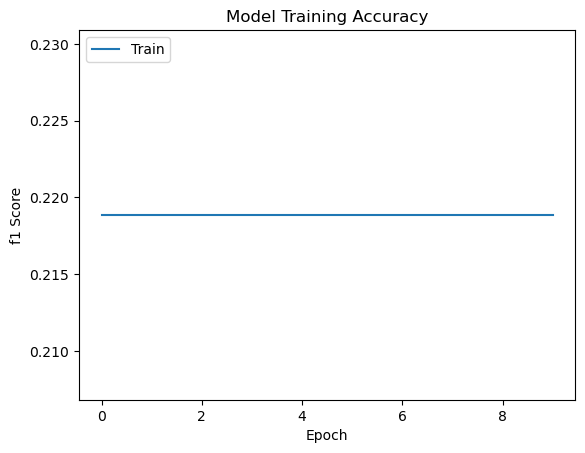

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2186 - loss: 0.2753
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2202 - loss: 0.2751
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2186 - loss: 0.2735
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2201 - loss: 0.2746
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2170 - loss: 0.2715
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2165 - loss: 0.2713
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2177 - loss: 0.2720
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2185 - loss: 0.2720
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2193 - loss: 0.2723
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2184 - loss: 0.2719
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.2219 - loss: 0.2749


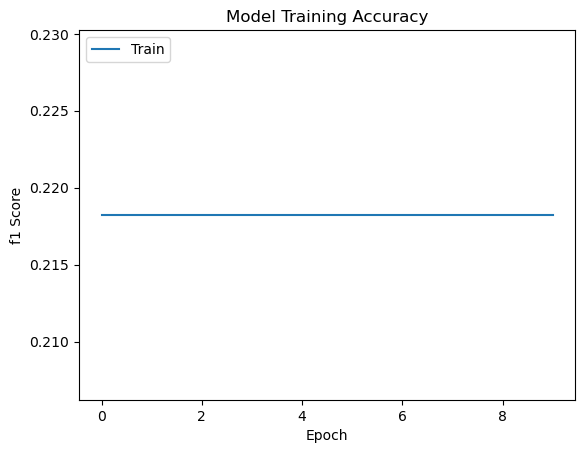

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - f1_score: 0.2176 - loss: 0.2709
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2180 - loss: 0.2711
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2188 - loss: 0.2724
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2179 - loss: 0.2722
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2167 - loss: 0.2708
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2170 - loss: 0.2706
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2206 - loss: 0.2730
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2188 - loss: 0.2719
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2195 - loss: 0.2722
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2201 - loss: 0.2714
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2178 - loss: 0.2697


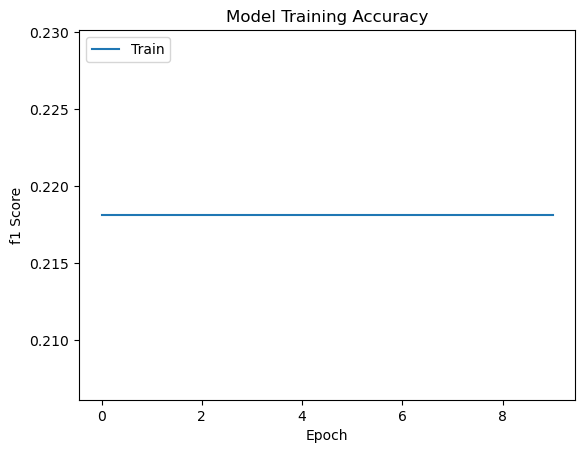

Epoch 1/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2176 - loss: 0.2706
Epoch 2/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - f1_score: 0.2173 - loss: 0.2702
Epoch 3/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2202 - loss: 0.2721
Epoch 4/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2206 - loss: 0.2721
Epoch 5/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2169 - loss: 0.2690
Epoch 6/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2169 - loss: 0.2701
Epoch 7/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2186 - loss: 0.2702
Epoch 8/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2172 - loss: 0.2704
Epoch 9/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - f1_score: 0.2184 - loss: 0.2702
Epoch 10/10
1830/1830 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - f1_score: 0.2202 - loss: 0.2717
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2161 - loss: 0.2700


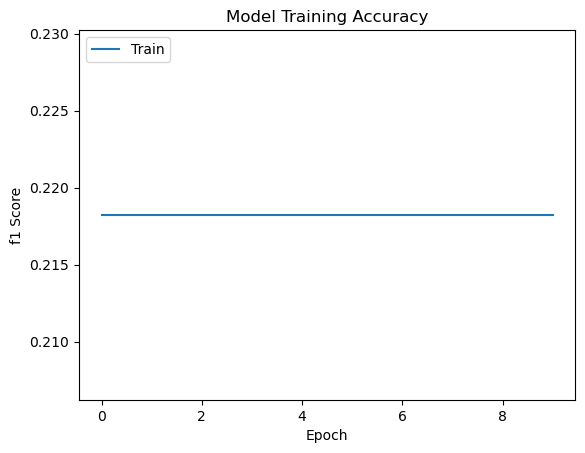

Mean f1_score: 0.218 +/- 0.001


In [17]:
#x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

#Model 1 or Model 2
model = model_2

#Number of folds
kfold = KFold(n_splits = 4, shuffle=True, random_state=seed)

#List to store the scores
scores = []

model.summary()

#For each fold
for train_index, test_index in kfold.split(x_train,y_train):
    # Split the data into train and test sets
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    X_train, X_test = x_train[train_index], x_train[test_index]

    # Fit the model on the training data
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, class_weight = class_weights)

    # Evaluate the model on the test data
    score = model.evaluate(X_test, Y_test)

    # Append the score to the scores list
    scores.append(score[1])
    plt.plot(history.history['f1_score'])
    plt.title('Model Training Accuracy')
    plt.ylabel('f1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
  
# Print the mean and standard deviation of the scores
print(f'Mean f1_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

### Final Model Fit

Epoch 1/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - f1_score: 0.2169 - loss: 0.2694 - val_f1_score: 0.2184 - val_loss: 0.2703
Epoch 2/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - f1_score: 0.2208 - loss: 0.2719 - val_f1_score: 0.2184 - val_loss: 0.2702
Epoch 3/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - f1_score: 0.2175 - loss: 0.2701 - val_f1_score: 0.2184 - val_loss: 0.2702
Epoch 4/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - f1_score: 0.2177 - loss: 0.2698 - val_f1_score: 0.2184 - val_loss: 0.2701
Epoch 5/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - f1_score: 0.2188 - loss: 0.2707 - val_f1_score: 0.2184 - val_loss: 0.2701
Epoch 6/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - f1_score: 0.2180 - loss: 0.2690 - val_f1_score: 0.2184 - val_loss: 0.2700
Epoch 7/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - f1_score: 0.2186 - loss: 0.2698 - val_f1_score: 0.2184 - val_loss: 0.2700
Epoch 8/10
2440/2440 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - f1_score: 0.2180 - loss: 0

[]

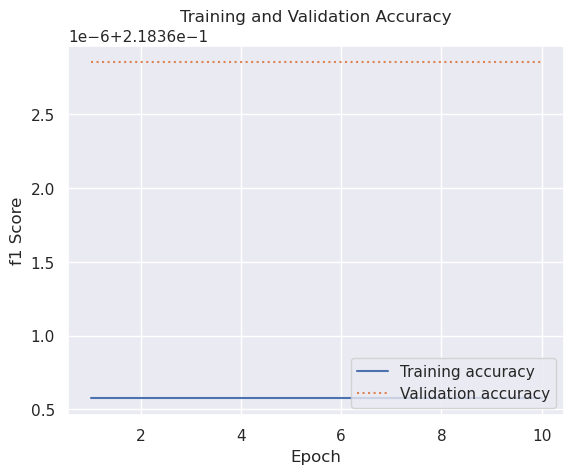

In [18]:
#Final fit
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, class_weight = class_weights)

#F1 Score
sns.set()
acc = hist.history['f1_score']
val = hist.history['val_f1_score']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('f1 Score')
plt.legend(loc='lower right')
plt.plot()

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


Text(109.44999999999997, 0.5, 'Actual label')

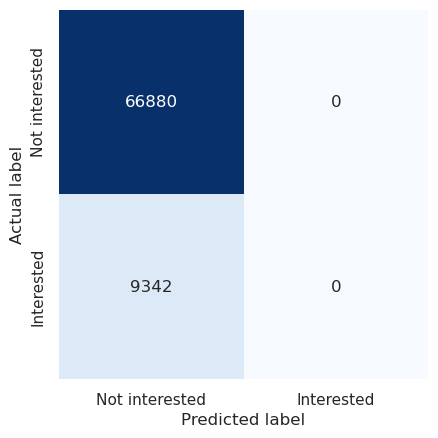

In [19]:
#Confusion Matrix
y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Not interested', 'Interested']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')